<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/NGLextractionprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

from neqsim.process import stream, expander, heater, compsplitter, separator, heatExchanger
from neqsim.thermo import fluid, printFrame
from neqsim.process import compsplitter, compressor, splitter, cooler, separator3phase, getProcess, clearProcess, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle2, setpoint, calculator


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 27.7 MB/s eta 0:00:00


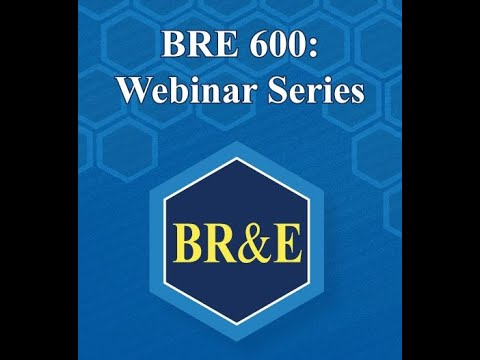

In [18]:
# NGL extraction process
from IPython.display import YouTubeVideo
YouTubeVideo('LrwlUReymlw', width=600, height=400)

# NGL extraction plant

In [8]:
#Feed gas
fluidcomposition = {'ComponentName':  ["nitrogen", "CO2", "methane", "ethane", "propane", "i-butane", "n-butane", "i-pentane", "n-pentane", "n-hexane", "C7", "C8", "C9", "C10-C11", "C12-C13", "C14-C15", "C16-C18", "C19-C20", "C21-C23", "C24-C29", "C30"],
      'MolarComposition[-]':  [0.5901, 0.00704, 64.423, 8.0634, 4.8112, 0.9095, 1.7896, 0.6577, 0.7712, 0.8545, 1.2025, 1.2507, 0.7571, 1.5015, 1.3053, 1.1353, 1.4328, 0.802, 1.0127, 1.4921, 2.9922],
      'MolarMass[kg/mol]': [None,None, None,None,None,None,None,None,None,None,0.09832, 0.11227, 0.12627, 0.14689, 0.174, 0.202, 0.237, 0.272, 0.307, 0.367, 0.594],
      'RelativeDensity[-]': [None,None, None,None,None,None,None,None,None,None, 0.737, 0.758, 0.775, 0.794, 0.814, 0.830, 0.846, 0.860, 0.872, 0.889, 0.935]
}
fluidcompositiondf = pd.DataFrame(fluidcomposition)
fluid1 = fluid_df(fluidcompositiondf, lastIsPlusFraction=False)
fluid1.setMixingRule('classic')

clearProcess()

streamfeed = stream(fluid1)

inletheater = heater(streamfeed)
inletheater.setOutPressure(110.0, 'bara')
inletheater.setOutTemperature(25.0, 'C')

separatorinlet = separator(inletheater.getOutletStream())

runProcess()

In [9]:
printFrame(separatorinlet.getGasOutStream().getFluid())

| 0                  | 1           | 2           | 3   | 4   | 5   | 6               |
|:-------------------|:------------|:------------|:----|:----|:----|:----------------|
|                    | total       | GAS         |     |     |     |                 |
| nitrogen           | 9.03421E-3  | 9.03421E-3  |     |     |     | [mole fraction] |
| CO2                | 7.72754E-5  | 7.72754E-5  |     |     |     | [mole fraction] |
| methane            | 8.7205E-1   | 8.7205E-1   |     |     |     | [mole fraction] |
| ethane             | 7.5403E-2   | 7.5403E-2   |     |     |     | [mole fraction] |
| propane            | 2.9109E-2   | 2.9109E-2   |     |     |     | [mole fraction] |
| i-butane           | 3.88989E-3  | 3.88989E-3  |     |     |     | [mole fraction] |
| n-butane           | 6.06717E-3  | 6.06717E-3  |     |     |     | [mole fraction] |
| i-pentane          | 1.42372E-3  | 1.42372E-3  |     |     |     | [mole fraction] |
| n-pentane          | 1.39327E-3  | 1.3932

In [10]:
#NGL expander code

feedstream = separatorinlet.getGasOutStream()
feedstream.setFlowRate(10.0, 'MSm3/day')

pressureNGL = 50.6
onshoreplant_inlet_pressure = 110.0
onshoreplant_inlet_temperature = 20.0

clearProcess()

inletheater = heater(feedstream)
inletheater.setOutPressure(onshoreplant_inlet_pressure, 'bara')
inletheater.setOutTemperature(onshoreplant_inlet_temperature, 'C')

heatEx = heatExchanger(inletheater.getOutStream())
heatEx.setName("cross heat-exchanger")
heatEx.setGuessOutTemperature(273.15 - 30.0)
heatEx.setUAvalue(3000e3) #assumes an UA vlue of 3000 MW/m2K

expanderKarsto = expander(heatEx.getOutStream(0), pressureNGL)
expanderKarsto.setOutletPressure(pressureNGL)
expanderKarsto.setIsentropicEfficiency(0.75) # assume same efficiency as for compressors

scrubberNGL = separator(expanderKarsto.getOutletStream())

recyOut = stream(scrubberNGL.getGasOutStream().clone())

gasResycle = recycle2("gas resycle")
gasResycle.addStream(scrubberNGL.getGasOutStream())
gasResycle.setOutletStream(recyOut)

heatEx.setFeedStream(1, recyOut)

gasfromdeethanizer = stream(heatEx.getOutStream(1).clone())

gasmixer = mixer('gas mixer')
gasmixer.addStream(heatEx.getOutStream(1))
gasmixer.addStream(gasfromdeethanizer)

dryGasExportCompressor = compressor(gasmixer.getOutletStream())
dryGasExportCompressor.setOutletPressure(100.0, 'bara')
dryGasExportCompressor.setIsentropicEfficiency(0.75)

exportDryGas = stream(dryGasExportCompressor.getOutStream())

NGLvalve1 = valve(scrubberNGL.getLiquidOutStream())
NGLvalve1.setOutletPressure(30.0)

#FRACTIONATION PROCESS
deethanizer = distillationColumn(trays=5, reboil=True, condenser=False, name="deethanizer")
deethanizer.addFeedStream(NGLvalve1.getOutStream(),5)
deethanizer.getReboiler().setOutTemperature(273.15+105.0)
deethanizer.setTopPressure(30.0)
deethanizer.setBottomPressure(32.0)

compressorgasdeethanizer = compressor(deethanizer.getGasOutStream())
compressorgasdeethanizer.setOutletPressure(pressureNGL, 'bara')

nglGasResycle = recycle2("gas resycle 2")
nglGasResycle.addStream(compressorgasdeethanizer.getOutStream())
nglGasResycle.setOutletStream(gasfromdeethanizer)

valvetodebutanizer = valve(deethanizer.getLiquidOutStream())
valvetodebutanizer.setOutletPressure(14.0)

debutanizer = distillationColumn(trays=10, reboil=True, condenser=True, name="debutanizer")
debutanizer.addFeedStream(valvetodebutanizer.getOutStream(),9)
debutanizer.getCondenser().setRefluxRatio(0.1)
debutanizer.getCondenser().setTotalCondenser(True)
debutanizer.getReboiler().setOutTemperature(273.15+163.0);
debutanizer.setTopPressure(12.8)
debutanizer.setBottomPressure(15.0)

onshoreprocess = getProcess()

In [11]:
thread = onshoreprocess.runAsThread()
thread.join(60 * 60 * 1000)   # 60 min maks tid

In [12]:
#mass balance onshore process should be close to 0% lost
massbalanceonshore = (feedstream.getFlowRate('kg/hr') - exportDryGas.getFlowRate('kg/hr') - debutanizer.getLiquidOutStream().getFlowRate('kg/hr') - debutanizer.getGasOutStream().getFlowRate('kg/hr') )/feedstream.getFlowRate('kg/hr')

print('mass lost % ',massbalanceonshore*100)

mass lost %  0.4965471601187552


In [13]:
print('feed gas rate ', feedstream.getFlowRate('MSm3/day'), ' MSm3/day')
printFrame(inletheater.getOutStream().getFluid())

feed gas rate  10.000000000000002  MSm3/day
| 0                  | 1           | 2           | 3           | 4   | 5   | 6               |
|:-------------------|:------------|:------------|:------------|:----|:----|:----------------|
|                    | total       | GAS         | OIL         |     |     |                 |
| nitrogen           | 9.03421E-3  | 9.03421E-3  | 1.55259E-3  |     |     | [mole fraction] |
| CO2                | 7.72754E-5  | 7.72754E-5  | 6.91749E-5  |     |     | [mole fraction] |
| methane            | 8.7205E-1   | 8.7205E-1   | 3.67397E-1  |     |     | [mole fraction] |
| ethane             | 7.5403E-2   | 7.5403E-2   | 1.02593E-1  |     |     | [mole fraction] |
| propane            | 2.9109E-2   | 2.9109E-2   | 8.74908E-2  |     |     | [mole fraction] |
| i-butane           | 3.88989E-3  | 3.88989E-3  | 1.93784E-2  |     |     | [mole fraction] |
| n-butane           | 6.06717E-3  | 6.06717E-3  | 4.00908E-2  |     |     | [mole fraction] |
| i-pe

In [14]:
#De-ethanizer results
print('gas from deethanizer')
printFrame(deethanizer.getGasOutStream().getFluid())
print('liquid from deethanizer')
printFrame(deethanizer.getLiquidOutStream().getFluid())

gas from deethanizer
| 0                  | 1           | 2                  | 3   | 4   | 5   | 6               |
|:-------------------|:------------|:-------------------|:----|:----|:----|:----------------|
|                    | total       | GAS                |     |     |     |                 |
| nitrogen           | 2.78545E-3  | 2.78545E-3         |     |     |     | [mole fraction] |
| CO2                | 1.45524E-4  | 1.45524E-4         |     |     |     | [mole fraction] |
| methane            | 7.23315E-1  | 7.23315E-1         |     |     |     | [mole fraction] |
| ethane             | 2.17227E-1  | 2.17227E-1         |     |     |     | [mole fraction] |
| propane            | 5.17951E-2  | 5.17951E-2         |     |     |     | [mole fraction] |
| i-butane           | 2.16869E-3  | 2.16869E-3         |     |     |     | [mole fraction] |
| n-butane           | 2.21223E-3  | 2.21223E-3         |     |     |     | [mole fraction] |
| i-pentane          | 1.91244E-4  | 1.

In [15]:
#debutanizer results
print('LPG from top debutanizer ')
printFrame(debutanizer.getGasOutStream().getFluid())
print('C5+ from bottom debutanizer ')
printFrame(debutanizer.getLiquidOutStream().getFluid())

LPG from top debutanizer 
| 0                  | 1           | 2                  | 3   | 4   | 5   | 6               |
|:-------------------|:------------|:-------------------|:----|:----|:----|:----------------|
|                    | total       | OIL                |     |     |     |                 |
| nitrogen           | 3.11266E-8  | 3.11266E-8         |     |     |     | [mole fraction] |
| CO2                | 1.94625E-6  | 1.94625E-6         |     |     |     | [mole fraction] |
| methane            | 4.60158E-4  | 4.60158E-4         |     |     |     | [mole fraction] |
| ethane             | 5.46086E-2  | 5.46086E-2         |     |     |     | [mole fraction] |
| propane            | 6.1516E-1   | 6.1516E-1          |     |     |     | [mole fraction] |
| i-butane           | 1.17164E-1  | 1.17164E-1         |     |     |     | [mole fraction] |
| n-butane           | 1.65591E-1  | 1.65591E-1         |     |     |     | [mole fraction] |
| i-pentane          | 2.3177E-2  

In [16]:
print('propane in dry export gas ', exportDryGas.getFluid().getComponent('propane').getx()*100.0, ' mol%')
print('LPG production rat ', debutanizer.getGasOutStream().getFlowRate('idSm3/hr')*24.0 , ' Sm3/day')
print('C5+ rate ', debutanizer.getLiquidOutStream().getFlowRate('idSm3/hr')*24.0, ' Sm3/day')
print('temperature in NGL scrubber ', expanderKarsto.getOutStream().getTemperature('C'))
print('temperature LPG extraction reflux condenser ', debutanizer.getGasOutStream().getTemperature('C'))
print('GCV ', exportDryGas.GCV()/1e6, ' MJ/m3')

print('duty deethanizer reboiler ', deethanizer.getReboiler().getDuty()/1e6, ' MW')
print('duty debutanizer reboiler ', debutanizer.getReboiler().getDuty()/1e6, ' MW')
print('duty debutanizer condenser ', debutanizer.getCondenser().getDuty()/1e6, ' MW')
propaneRecovery = 1.0 - exportDryGas.getFluid().getComponent('propane').getNumberOfmoles()/feedstream.getFluid().getComponent('propane').getNumberOfmoles()
ibutaneRecovery = 1.0 - exportDryGas.getFluid().getComponent('i-butane').getNumberOfmoles()/feedstream.getFluid().getComponent('i-butane').getNumberOfmoles()
nbutaneRecovery = 1.0 - exportDryGas.getFluid().getComponent('n-butane').getNumberOfmoles()/feedstream.getFluid().getComponent('n-butane').getNumberOfmoles()
print('propane recovery ' ,propaneRecovery)
print('i-butane recovery ' ,ibutaneRecovery)
print('n-butane recovery ' ,nbutaneRecovery)

propane in dry export gas  1.5676944799207406  mol%
LPG production rat  922.1760915669067  Sm3/day
C5+ rate  50.18916804695333  Sm3/day
temperature in NGL scrubber  -56.627611494795445
temperature LPG extraction reflux condenser  43.634323665182364
GCV  42.912603551551626  MJ/m3
duty deethanizer reboiler  8.928232469927742  MW
duty debutanizer reboiler  2.4773622557589494  MW
duty debutanizer condenser  -2.4784755187465883  MW
propane recovery  0.4763538860091807
i-butane recovery  0.7878657540164207
n-butane recovery  0.8538597722977967


In [17]:
print('export gas')
printFrame(exportDryGas.getFluid())

export gas
| 0                  | 1           | 2                  | 3   | 4   | 5   | 6               |
|:-------------------|:------------|:-------------------|:----|:----|:----|:----------------|
|                    | total       | GAS                |     |     |     |                 |
| nitrogen           | 9.29151E-3  | 9.29151E-3         |     |     |     | [mole fraction] |
| CO2                | 7.94248E-5  | 7.94248E-5         |     |     |     | [mole fraction] |
| methane            | 8.96874E-1  | 8.96874E-1         |     |     |     | [mole fraction] |
| ethane             | 7.61544E-2  | 7.61544E-2         |     |     |     | [mole fraction] |
| propane            | 1.56769E-2  | 1.56769E-2         |     |     |     | [mole fraction] |
| i-butane           | 8.48681E-4  | 8.48681E-4         |     |     |     | [mole fraction] |
| n-butane           | 9.1191E-4   | 9.1191E-4          |     |     |     | [mole fraction] |
| i-pentane          | 8.7829E-5   | 8.7829E-5   